## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast

## Data preparation

In [2]:
# Parameters to choose:

# Minimum number of movies to consider a country,language or genre
Min_count_count = 20
Min_lang_count = 20
Min_genre_count = 20

# Sucess threshold for a movie to be considered sucessful on the normalized revenue
Sucess_revenue_threshold = 1.5


### Movie preparation

In [3]:
def movie_data_processing():
    movies = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)

    movies.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
    movies.drop('Freebase movie ID', axis=1, inplace=True)
    movies["Movie languages"]=movies["Movie languages"].map(lambda x: set(ast.literal_eval(x).values()))
    movies["Movie countries"]=movies["Movie countries"].map(lambda x: set(ast.literal_eval(x).values()))
    movies['Movie genres']=movies['Movie genres'].map(lambda x: set(ast.literal_eval(x).values()))

    return movies
movies = movie_data_processing()

In [4]:
def process_dict_columns(movies):
    union_lang = set().union(*movies["Movie languages"])
    union_count = set().union(*movies['Movie countries'])
    union_genres = set().union(*movies['Movie genres'])

    print("Number of languages: ", len(union_lang))
    print("Number of countries: ", len(union_count))
    print("Number of genres: ", len(union_genres))



    lang_count = {}
    for lang in union_lang:
        lang_count[lang] = 0
    for lang in movies["Movie languages"]:
        for l in lang:
            lang_count[l] += 1
    lang_count = pd.DataFrame.from_dict(lang_count, orient='index', columns=['Count'])
    lang_count.sort_values(by=['Count'], ascending=False, inplace=True)


    lang_count = lang_count[lang_count['Count'] > Min_lang_count]
    print(f"Number of languages with more than {Min_lang_count} movies: ", len(lang_count))


    genre_count = {}
    for genre in union_genres:
        genre_count[genre] = 0
    for genre in movies['Movie genres']:
        for g in genre:
            genre_count[g] += 1
    genre_count = pd.DataFrame.from_dict(genre_count, orient='index', columns=['Count'])
    genre_count.sort_values(by=['Count'], ascending=False, inplace=True)


    genre_count = genre_count[genre_count['Count'] > Min_genre_count]
    print(f"Number of genres with more than {Min_genre_count} movies: ", len(genre_count))

    count_count = {}
    for count in union_count:
        count_count[count] = 0
    for count in movies['Movie countries']:
        for c in count:
            count_count[c] += 1
    count_count = pd.DataFrame.from_dict(count_count, orient='index', columns=['Count'])
    count_count.sort_values(by=['Count'], ascending=False, inplace=True)



    count_count = count_count[count_count['Count'] > Min_count_count]
    print(f"Number of countries with more than {Min_count_count} movies: ", len(count_count))

        
    movies["Movie languages"] = movies["Movie languages"].map(lambda x: set([l for l in x if l in lang_count.index]))
    movies["Movie countries"] = movies["Movie countries"].map(lambda x: set([c for c in x if c in count_count.index]))
    movies["Movie genres"] = movies["Movie genres"].map(lambda x: set([g for g in x if g in genre_count.index]))

    movies.drop(movies[movies["Movie languages"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie countries"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie genres"].map(lambda x: len(x)) == 0].index, inplace=True)
    return movies

movies = process_dict_columns(movies)

Number of languages:  207
Number of countries:  147
Number of genres:  363
Number of languages with more than 20 movies:  81
Number of genres with more than 20 movies:  245
Number of countries with more than 20 movies:  88


In [5]:
## CAREFUL This will make that many films will be published the 1st of January
def modify_movie_release_date(movies):
    movies.drop(movies[movies['Movie release date'].map(lambda x: type(x)!=str)].index, inplace=True)
    
    #little error in the date
    movies.loc[movies['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'

    movies["Movie release date"]=movies["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    return movies

movies = modify_movie_release_date(movies)

### Nan in revenue column

In [6]:
#drop when movie box office revenue is NaN
movies=movies.dropna(subset=['Movie box office revenue'])


In [7]:
tmdb = pd.read_csv('data/tmdb-movies.csv', sep=',', header=0)
joined = movies.join(tmdb.set_index('original_title'), on='Movie name', how='inner', lsuffix='_left', rsuffix='_right')

In [8]:
nbr = ((1-(joined['Movie box office revenue']>0)) & (joined['revenue']>0)).sum()
print(f"Number of movies with revenue in tmdb but not in our dataset: {nbr}")

Number of movies with revenue in tmdb but not in our dataset: 0


### Characters

In [9]:
def characters_data_process():
    characters = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
    characters = characters.rename(columns={0: 'Wikipedia movie ID', 1: 'Freebase movie ID', 2: 'Movie release date', 3: 'Character name', 4: 'Actor date of birth', 5: 'Actor gender', 6: 'Actor height (in meters)', 7: 'Actor ethnicity (Freebase ID)', 8: 'Actor name', 9: 'Actor age at movie release', 10: 'Freebase character/actor map ID', 11: 'Freebase character ID', 12: 'Freebase actor ID'})
    characters.drop('Freebase movie ID', axis=1, inplace=True)
    characters.drop('Freebase character/actor map ID', axis=1, inplace=True)
    characters.drop('Freebase character ID', axis=1, inplace=True)
    characters.drop('Freebase actor ID', axis=1, inplace=True)

    ## This one might be usefull
    characters.drop('Actor ethnicity (Freebase ID)', axis=1, inplace=True)


    characters["Movie release date"] = characters["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    
    #little error in the date
    characters.loc[characters['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'
    
    characters.dropna(subset=['Character name',"Actor name"], inplace=True)

    characters = characters[characters['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
    return characters
characters = characters_data_process()

### Plot Summaries

In [10]:
from matplotlib.pyplot import plot


def plot_summaries_data_process():
    plot_summaries = pd.read_csv('data/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
    plot_summaries.columns = ['Wikipedia movie ID', 'Plot summary']
    plot_summaries.dropna(subset=['Plot summary'], inplace=True)
    return plot_summaries[plot_summaries['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
plot_summaries = plot_summaries_data_process()

### First definition of success

In [11]:
movies['Movie Year Release'] = movies['Movie release date'].map(lambda x: int(x.split('-')[0]))

mean_revenue_year = movies.groupby('Movie Year Release')['Movie box office revenue'].mean()

for i in movies.index:
    movies.loc[i, 'Normalized revenue'] = movies.loc[i, 'Movie box office revenue']/mean_revenue_year[movies.loc[i, 'Movie Year Release']]

movies["Success"] = movies["Normalized revenue"]>Sucess_revenue_threshold

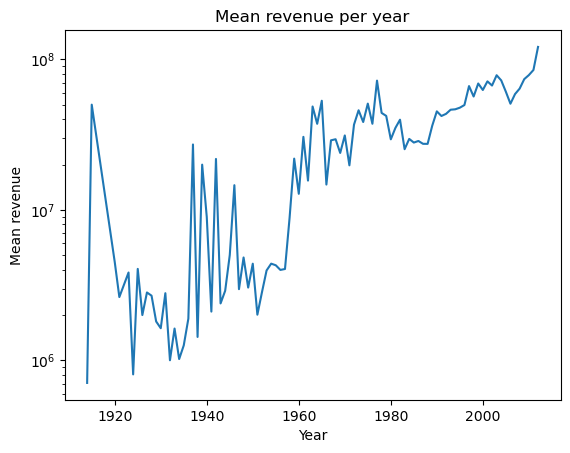

In [12]:

plt.semilogy(mean_revenue_year)
plt.title("Mean revenue per year")
plt.xlabel("Year")
plt.ylabel("Mean revenue")
plt.show()


### Add rotten tomatoes critic score

In [13]:
def processing_rotten_tomatoes_score():
    rotten_movies = pd.read_csv('data/rotten_tomatoes_movies.csv', sep=',', header=0)

    rotten_movies.drop('rotten_tomatoes_link', axis=1, inplace=True)
    rotten_movies.drop('movie_info', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_status', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_count', axis=1, inplace=True)
    rotten_movies.drop('audience_status', axis=1, inplace=True)
    rotten_movies.drop('audience_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_top_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_fresh_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_rotten_critics_count', axis=1, inplace=True)
    # rotten_movies.drop('original_release_date', axis=1, inplace=True)
    rotten_movies.drop('streaming_release_date', axis=1, inplace=True)
    rotten_movies.drop('runtime', axis=1, inplace=True)
    rotten_movies.drop('genres', axis=1, inplace=True)
    rotten_movies.drop('content_rating', axis=1, inplace=True)
    rotten_movies.drop('actors', axis=1, inplace=True)

    rotten_movies.dropna(subset=['movie_title', 'audience_rating', 'tomatometer_rating'], inplace=True)
    return rotten_movies

rotten_movies = processing_rotten_tomatoes_score()
joined_movies = movies.join(rotten_movies.set_index('movie_title'), on='Movie name', how='inner')


# 8k film to only 6k
# The are error on the merge => the sorcerer's apprentice is not the same movie
# Need to fixed, maybe using the release date

In [14]:
movies = joined_movies

## Analysis

In [15]:
movies.head()

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie Year Release,Normalized revenue,Success,critics_consensus,directors,authors,original_release_date,production_company,tomatometer_rating,audience_rating
7,10408933,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,{English Language},{United States of America},"{Black-and-white, Musical, Comedy}",1938,2.516221,True,NaN,Henry King,"Lamar Trotti, Kathryn Scola, Irving Berlin, Ri...",1938-08-16,20th Century Fox Film Corporation,80.0,46.0
13,171005,Henry V,1989-11-08,10161099.0,137.0,{English Language},{United Kingdom},"{Period piece, Drama, Costume drama, War film,...",1989,0.280666,False,Pehaps Kenneth Branagh's most fully realized S...,Kenneth Branagh,Kenneth Branagh,1989-11-08,MGM Home Entertainment,100.0,89.0
17,77856,Mary Poppins,1964-08-27,102272727.0,139.0,{English Language},{United States of America},"{Children's Fantasy, Fantasy, Drama, Family Fi...",1964,2.742002,True,A lavish modern fairy tale celebrated for its ...,Robert Stevenson,"Don DaGradi, Bill Walsh",1964-08-26,Walt Disney Productions,100.0,86.0
29,156558,Baby Boy,2001-06-27,29381649.0,123.0,{English Language},{United States of America},"{Coming of age, Drama, Crime Fiction}",2001,0.411379,False,"Preachy and repetitive in parts, Baby Boy stil...",John Singleton,John Singleton,2001-06-27,Columbia Pictures,71.0,87.0
49,261237,The Gods Must Be Crazy,1980-01-01,34331783.0,109.0,"{Afrikaans Language, English Language}",{South Africa},"{Slapstick, World cinema, Comedy, Cult, Indie,...",1980,1.166923,False,NaN,Jamie Uys,Jamie Uys,1980-01-01,20th Century Fox Film Corporat,85.0,84.0


In [16]:
characters.head()

,Wikipedia movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor name,Actor age at movie release
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0


In [17]:
movies[movies["Movie box office revenue"]>1e7].sort_values(by=["audience_rating", "tomatometer_rating"], ascending=False).head(20)

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie Year Release,Normalized revenue,Success,critics_consensus,directors,authors,original_release_date,production_company,tomatometer_rating,audience_rating
36402,2466773,The Godfather,1972-03-15,268500000.0,177.0,"{Latin Language, English Language, Italian Lan...",{United States of America},"{Family Drama, Period piece, Drama, Crime Fict...",1972,7.292592,True,One of Hollywood's greatest critical and comme...,Francis Ford Coppola,"Francis Ford Coppola, Mario Puzo",1972-03-24,Paramount Pictures,98.0,98.0
26366,30625,The Shawshank Redemption,1994-09-10,28341469.0,142.0,{English Language},{United States of America},"{Drama, Escape Film, Crime Fiction, Buddy film...",1994,0.608585,False,"The Shawshank Redemption is an uplifting, deep...",Frank Darabont,Frank Darabont,1994-09-10,Columbia Pictures,91.0,98.0
25386,65834,Schindler's List,1993-11-30,321306305.0,186.0,"{English Language, Polish Language, French Lan...",{United States of America},"{Biographical film, Period piece, Tragedy, Dra...",1993,6.944183,True,Schindler's List blends the abject horror of t...,Steven Spielberg,Steven Zaillian,1993-12-15,Universal Pictures,97.0,97.0
59261,31557,"The Good, the Bad and the Ugly",1966-12-23,25100000.0,177.0,"{English Language, Italian Language}","{Italy, West Germany, Spain}","{Revisionist Western, Spaghetti Western, Weste...",1966,1.704413,True,Arguably the greatest of the spaghetti western...,Sergio Leone,"Sergio Leone, Luciano Vincenzoni, Furio Scarpe...",1966-12-23,United Artists,97.0,97.0
78722,2812852,Love Jones,1997-03-14,12782749.0,108.0,{English Language},{United States of America},"{Romance Film, Romantic drama, Drama, Comedy, ...",1997,0.192424,False,NaN,Theodore Witcher,Theodore Witcher,1997-03-14,New Line Home Entertainment,73.0,97.0
9952,1897341,The Pianist,2002-05-24,120072577.0,142.0,"{Russian Language, English Language, German La...","{United Kingdom, Poland, France, Germany}","{Biographical film, War film, Drama, History}",2002,1.792322,True,"Well-acted and dramatically moving, The Pianis...",Roman Polanski,Ronald Harwood,2002-12-27,Focus Features,95.0,96.0
47117,21913863,One Flew Over the Cuckoo's Nest,1975-11-19,108981275.0,129.0,{English Language},{United States of America},"{Tragedy, Drama, Comedy, Indie, Comedy-drama, ...",1975,2.145094,True,The onscreen battle between Jack Nicholson and...,Milos Forman,"Bo Goldman, Lawrence Hauben",1975-11-19,United Artists,94.0,96.0
11421,5454803,The Lives of Others,2006-03-15,11286112.0,137.0,{German Language},{Germany},"{Thriller, Period piece, Drama, World cinema, ...",2006,0.222516,False,"Unlike more traditional spy films, The Lives o...",Florian Henckel von Donnersmarck,Florian Henckel von Donnersmarck,2006-03-23,Sony Pictures Classics,93.0,96.0
66299,54173,Pulp Fiction,1994-01-01,213928762.0,168.0,"{English Language, Spanish Language, French La...",{United States of America},"{Thriller, Drama, Crime Fiction, Crime Comedy,...",1994,4.593760,True,One of the most influential films of the 1990s...,Quentin Tarantino,"Quentin Tarantino, Roger Avary",1994-09-23,Miramax Films,92.0,96.0
27273,167857,The Usual Suspects,1994-01-01,23272306.0,108.0,"{English Language, Spanish Language, French La...","{United States of America, Germany}","{Thriller, Mystery, Neo-noir, Crime Fiction, E...",1994,0.499734,False,"Expertly shot and edited, The Usual Suspects g...",Bryan Singer,"Christopher McQuarrie, Bryan Singer",1995-08-16,Gramercy Pictures,89.0,96.0


# Economic success

We load economics data to compare the movie box office return through history. Furthermore, we analyse if economics data are related with success for some year 

In [18]:
!pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/e6/b3/388ab967a387cc92926f70e97688dd9a7189b29a0773db815ffc5289e2b5/yfinance-0.2.31-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
     - -------------------------------------- 0.1/2.9 MB 1.4 MB/s eta 0:00:02
     --- ------------------------------------ 0.3/2.9 MB 2.0 MB/s eta 0:00:02
     ---- ----------------------------------- 0.3/2.9 MB 2.0 MB/s eta 0:00:02
     ----- ---------------------------------- 0.4/2.9 MB 1.7 MB/s eta 0:00:02
     -------- ------------------------------- 0.6/2.9 MB 2.3 MB/s eta 0:00:02
     ---------- ----------------------------- 0.8/2.9 MB 2.5 MB/s eta 0:00:01
     ------------ --------------------------- 0.9/2.9 MB 2.5 MB/s eta 0:00:01
     ------------- -------------------------- 1.0/2.9 MB 2.4 MB/s eta 0:00:01
     --------------- -------

In [19]:
import yfinance

financial_indicator = yfinance.download("^GSPC", start = pd.to_datetime(movies["Movie Year Release"].min(), format="%Y"), end=pd.to_datetime(movies["Movie Year Release"].max(), format="%Y"))



[*********************100%%**********************]  1 of 1 completed


In [20]:
pd.to_datetime(movies["Movie Year Release"].min(), format="%Y")
financial_indicator["Close"]/financial_indicator["Close"][0]


Date
1927-12-30     1.000000
1928-01-03     1.005663
1928-01-04     1.003397
1928-01-05     0.993771
1928-01-06     1.000000
                ...    
2011-12-23    71.649489
2011-12-27    71.655157
2011-12-28    70.761043
2011-12-29    71.518688
2011-12-30    71.211777
Name: Close, Length: 21097, dtype: float64

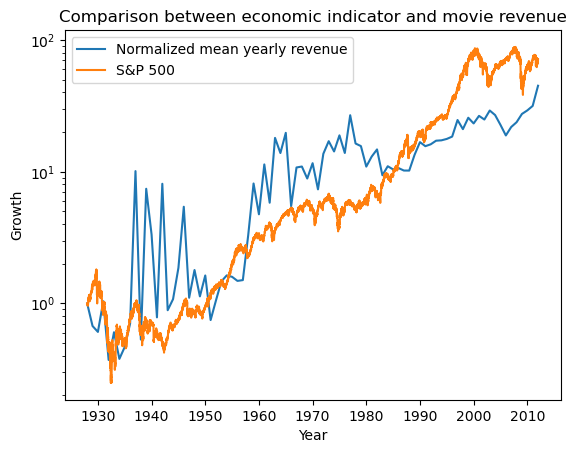

In [21]:
financial_revenue_year = mean_revenue_year[mean_revenue_year.index>financial_indicator.index.year.min()]
financial_revenue_year.index = pd.to_datetime(financial_revenue_year.index, format="%Y") 
plt.semilogy(financial_revenue_year/financial_revenue_year[0], label="Normalized mean yearly revenue")
plt.semilogy(financial_indicator["Close"]/financial_indicator["Close"][0], label="S&P 500")
plt.title("Comparison between economic indicator and movie revenue")
plt.xlabel("Year")
plt.ylabel("Growth")
plt.legend()
plt.show()

## Analysis of inflation

In [22]:
!pip install cpi

  Obtaining dependency information for cpi from https://files.pythonhosted.org/packages/9c/b6/d46fc8c175ca7506ee9c9c7a42961e209676621bbf1f390facac428088a4/cpi-1.0.22-py2.py3-none-any.whl.metadata
  Obtaining dependency information for click from https://files.pythonhosted.org/packages/00/2e/d53fa4befbf2cfa713304affc7ca780ce4fc1fd8710527771b58311a3229/click-8.1.7-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/31.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/31.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/31.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/31.0 MB 330.3 kB/s eta 0:01:34
   ---------------------------------------- 0.1/31.0 MB 731.4 kB/s eta 0:00:43
   ---------------------------------------- 0.2/31.0 MB 1.1 MB/s eta 0:00:27
   ---------------------------------------- 0.3/31.0 MB 1.3 MB/s eta 0:00:25
    --------------------------------------- 0.4/31.0 MB 1.4 MB/s eta 0:00:22
    ------

In [23]:
import cpi

cpi_df = cpi.series.get().to_dataframe()
cpi_df = cpi_df[cpi_df['period_type']=='monthly']
cpi_df['date'] = pd.to_datetime(cpi_df['date'])
cpi_df = cpi_df.set_index('date').sort_values(by="date")

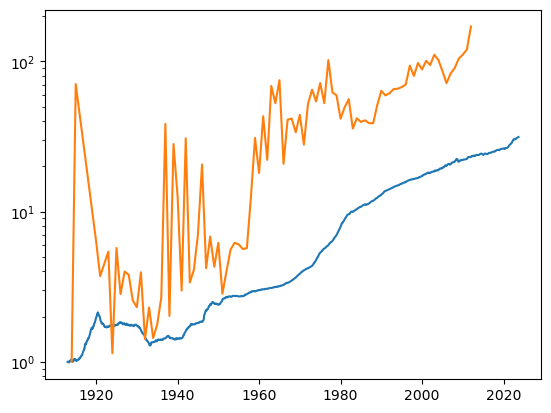

In [24]:
#inflation = cpi_df[(cpi_df.index>financial_revenue_year)]
mean_revenue_year.index = pd.to_datetime(mean_revenue_year.index, format="%Y")
plt.semilogy(cpi_df["value"]/(cpi_df["value"].iloc[0]))
plt.semilogy(mean_revenue_year/mean_revenue_year.iloc[0])


### Adjust the effect of inflation on the movie revenue

In [25]:
mean_revenue_year.iloc[0]

707932.0

In [26]:
movies["Inflated revenue"]=movies.apply(lambda x: cpi.inflate(x["Movie box office revenue"], x["Movie Year Release"]), axis=1)

In [27]:
movies.sort_values(by=["Movie Year Release","Inflated revenue"], ascending=[True, False]).head()

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie Year Release,Normalized revenue,Success,critics_consensus,directors,authors,original_release_date,production_company,tomatometer_rating,audience_rating,Inflated revenue
53319,15340505,Neptune's Daughter,1914-04-25,1000000.0,NaN,{English Language},{United States of America},"{Black-and-white, Silent film, Indie}",1914,1.412565,False,NaN,Edward Buzzell,"Dick Chevillat, Dorothy Kingsley, Ray Singer",1949-06-01,MGM Home Entertainment,100.0,59.0,2.926550e+07
2634,3333,The Birth of a Nation,1915-01-01,50000000.0,190.0,"{Silent film, English Language}",{United States of America},"{Drama, Costume drama, Indie, Black-and-white,...",1915,1.000000,False,"A deeply flawed cinematic landmark, The Birth ...",D.W. Griffith,"Frank Woods, D.W. Griffith, Frank E. Woods, Th...",1915-03-03,Gravitas,93.0,56.0,1.448787e+09
2634,3333,The Birth of a Nation,1915-01-01,50000000.0,190.0,"{Silent film, English Language}",{United States of America},"{Drama, Costume drama, Indie, Black-and-white,...",1915,1.000000,False,The Birth of a Nation overpowers its narrative...,Nate Parker,"Nate Parker, Jean McGianni Celestin",2016-10-07,Fox Searchlight Pictures,72.0,71.0,1.448787e+09
24953,4499436,Way Down East,1920-01-01,4500000.0,147.0,"{Silent film, English Language}",{United States of America},"{Romance Film, Romantic drama, Western, Drama,...",1920,1.000000,False,NaN,D.W. Griffith,"D.W. Griffith, Anthony Paul Kelly",1920-09-03,Kino Lorber,95.0,69.0,6.584737e+07
40247,1346905,The Kid,1921-01-01,2500000.0,60.0,"{Silent film, English Language}",{United States of America},"{Drama, Comedy, Indie, Black-and-white, Silent...",1921,0.949367,False,Charles Chaplin' irascible Tramp is given able...,Charles Chaplin,Charles Chaplin,1921-01-21,First National Pictures Inc.,100.0,95.0,4.087360e+07


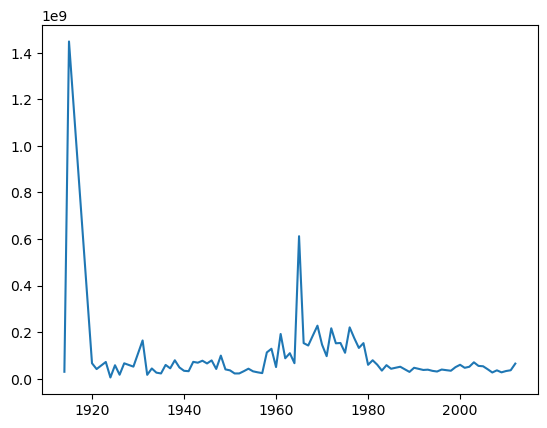

In [28]:
mean_infl_revenue_year = movies.groupby('Movie Year Release')['Inflated revenue'].median()
plt.plot(mean_infl_revenue_year)

# Actors' and films' success
First we need to define actor's success

In [67]:
characters.head(10)

,Wikipedia movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor name,Actor age at movie release
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0
5,975900,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,Pam Grier,52.0
6,975900,2001-08-24,Whitlock,1945-08-02,F,1.753,Joanna Cassidy,56.0
7,975900,2001-08-24,Big Daddy Mars,NaN,M,NaN,Richard Cetrone,NaN
8,975900,2001-08-24,Michael Descanso,1971-03-20,M,1.892,Liam Waite,30.0
9,975900,2001-08-24,Uno,NaN,M,NaN,Duane Davis,NaN


,size
count,25535.000000
mean,2.542393
std,4.261062
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,71.000000


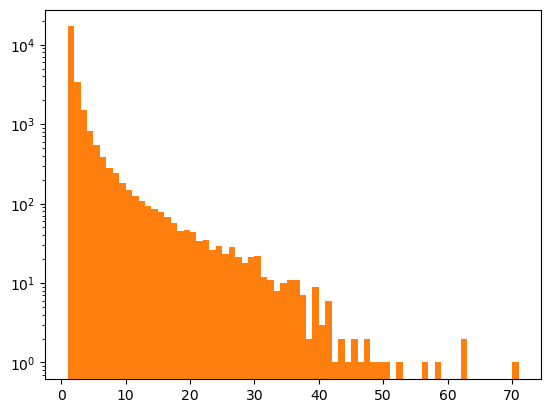

In [69]:
movie_actor = characters.groupby('Actor name')['Actor name'].agg(['size']).sort_values("size", ascending=False)
plt.hist(movie_actor, bins=70, log=True)
movie_actor.describe()

In [71]:
movie_actor.index

Index(['Samuel L. Jackson', 'Bruce Willis', 'Nicolas Cage', 'Robert De Niro',
       'John Goodman', 'Robin Williams', 'Christopher Walken', 'Danny DeVito',
       'Liam Neeson', 'Tom Hanks',
       ...
       'James Casey', 'James Carraway', 'James Carpinello', 'James Cagnard',
       'James Cada', 'James C. Burns', 'James Burrows', 'James Bullard',
       'James Broderick', '田村英里子'],
      dtype='object', name='Actor name', length=25535)

In [88]:
movie_actor['Wikipedia movie IDs'] = pd.Series([characters[characters['Actor name'].isin([actor])]['Wikipedia movie ID'].tolist() for actor in movie_actor.index],
                                                index=movie_actor.index)


In [95]:
movies[movies['Wikipedia movie ID'].isin(movie_actor['Wikipedia movie IDs'][0])]

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie Year Release,Normalized revenue,Success,critics_consensus,directors,authors,original_release_date,production_company,tomatometer_rating,audience_rating,Inflated revenue
7,10408933,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,{English Language},{United States of America},"{Black-and-white, Musical, Comedy}",1938,2.516221,True,NaN,Henry King,"Lamar Trotti, Kathryn Scola, Irving Berlin, Ri...",1938-08-16,20th Century Fox Film Corporation,80.0,46.0,7.472043e+07
13,171005,Henry V,1989-11-08,10161099.0,137.0,{English Language},{United Kingdom},"{Period piece, Drama, Costume drama, War film,...",1989,0.280666,False,Pehaps Kenneth Branagh's most fully realized S...,Kenneth Branagh,Kenneth Branagh,1989-11-08,MGM Home Entertainment,100.0,89.0,2.398142e+07
17,77856,Mary Poppins,1964-08-27,102272727.0,139.0,{English Language},{United States of America},"{Children's Fantasy, Fantasy, Drama, Family Fi...",1964,2.742002,True,A lavish modern fairy tale celebrated for its ...,Robert Stevenson,"Don DaGradi, Bill Walsh",1964-08-26,Walt Disney Productions,100.0,86.0,9.655040e+08
29,156558,Baby Boy,2001-06-27,29381649.0,123.0,{English Language},{United States of America},"{Coming of age, Drama, Crime Fiction}",2001,0.411379,False,"Preachy and repetitive in parts, Baby Boy stil...",John Singleton,John Singleton,2001-06-27,Columbia Pictures,71.0,87.0,4.855272e+07
49,261237,The Gods Must Be Crazy,1980-01-01,34331783.0,109.0,"{Afrikaans Language, English Language}",{South Africa},"{Slapstick, World cinema, Comedy, Cult, Indie,...",1980,1.166923,False,NaN,Jamie Uys,Jamie Uys,1980-01-01,20th Century Fox Film Corporat,85.0,84.0,1.219341e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81659,25920477,Source Code,2011-03-11,147332697.0,93.0,{English Language},"{United States of America, France}","{Thriller, Drama, Suspense, Action, Science Fi...",2011,1.733417,True,"Finding the human story amidst the action, dir...",Duncan Jones,"Ben Ripley, Billy Ray",2011-04-01,Summit Entertainment,92.0,82.0,1.916860e+08
81668,4492078,How to Eat Fried Worms,2006-08-25,13040527.0,98.0,{English Language},{United States of America},"{Film adaptation, Comedy, Drama, Family Film}",2006,0.257106,False,This Fear Factor for kids is good-natured and ...,Bob Dolman,"Thomas Rockwell, Bob Dolman",2006-08-25,New Line Cinema,60.0,47.0,1.893043e+07
81694,1191380,Wilde,1997-01-01,2158775.0,118.0,{English Language},"{Germany, United Kingdom, England, Japan}","{LGBT, Gay, Biographical film, Romance Film, P...",1997,0.032497,False,Wilde can't hope to communicate the entirety o...,Brian Gilbert,Julian Mitchell,1998-05-01,Sony Pictures Classics,71.0,73.0,3.936301e+06
81720,7761830,Spaced Invaders,1990-01-01,15369573.0,100.0,{English Language},{United States of America},"{Family Film, Science Fiction, Comedy, Alien F...",1990,0.340556,False,NaN,Patrick Read Johnson,"Scott Lawrence Alexander, Patrick Read Johnson",1990-04-27,Touchstone Pictures,8.0,51.0,3.441456e+07
